In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm

In [2]:
!ls

2D_smooth_01_s_03.png
3D_smooth_01_s_05.png
_disperse
_disperse_02
DisPerSe.ipynb
disperse_sdss7_coma_2D.ipynb
disperse_sdss7_coma.ipynb
DR5_cluster-catalog_v1.1.fits
main_gals-DR7.fit
README.md
SDSS7_coma_2D_ascii.txt
SDSS7_coma_2D_ascii.txt.NDnet
SDSS7_coma_2D_ascii.txt.NDnet.MSC
SDSS7_coma_2D_ascii.txt.NDnet_s3.up.NDskl
SDSS7_coma_2D_ascii.txt.NDnet_s3.up.NDskl.S001.a.NDskl
SDSS7_coma_ascii.txt
SDSS7_coma_ascii.txt.NDnet
SDSS7_coma_ascii.txt.NDnet.MSC
SDSS7_coma_ascii.txt.NDnet_s5.up.NDskl
SDSS7_coma_ascii.txt.NDnet_s5.up.NDskl.S001.RaDecZ.a.NDskl
SDSS_DR16.csv
SDSS_DR7.csv
test.ipynb
test_smooth.dat
visual.ipynb


In [14]:
galaxies = pd.read_csv('SDSS_DR7.csv')

In [17]:
# galaxies = galaxies.loc[galaxies['z'] <= 0.3]
# galaxies = galaxies.loc[galaxies['z'] > 0]
galaxies = galaxies.loc[galaxies['petroMag_r'] <= 17.77]
galaxies = galaxies.loc[galaxies['zWarning'] == 0]
galaxies = galaxies.loc[galaxies['zConf'] > 0.35]
# galaxies.columns = ['RA', 'DEC', 'Z', 'CX', 'CY', 'CZ', 'zErr', 'zConf', 'zWarning', 'type', 'petroMag_r']
# galaxies_rdz = galaxies[['RA', 'DEC', 'Z']]

In [18]:
galaxies

,ra,dec,z,cx,cy,cz,zErr,zConf,zWarning,type,petroMag_r
0,146.71421,-1.041304,0.021314,-0.835805,0.548725,-0.018173,0.000175,0.998538,0,3.0,14.86596
1,146.91945,-0.990492,0.213991,-0.837779,0.545736,-0.017286,0.000130,0.999355,0,3.0,17.73796
3,146.85983,-0.808902,0.126660,-0.837252,0.546635,-0.014118,0.000165,0.999525,0,3.0,17.45244
5,146.96390,-0.545003,0.055956,-0.838289,0.545143,-0.009512,0.000095,0.932335,0,3.0,17.39276
7,146.60721,-1.240753,0.090659,-0.834721,0.550247,-0.021654,0.000147,0.999779,0,3.0,16.49320
...,...,...,...,...,...,...,...,...,...,...,...
1599442,260.74317,31.944035,0.033893,-0.136500,-0.837515,0.529091,0.000157,0.999611,0,3.0,16.19189
1599444,260.80058,31.898992,0.159699,-0.135728,-0.838061,0.528423,0.000150,0.999659,0,3.0,17.39783
1599445,260.71601,32.024276,0.167412,-0.136778,-0.836718,0.530279,0.000139,0.999942,0,3.0,16.92561
1599446,260.69724,32.285628,0.111586,-0.136659,-0.834277,0.534140,0.000154,0.999824,0,3.0,16.59268


In [6]:
galaxies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651745 entries, 0 to 1599447
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RA          651745 non-null  float64
 1   DEC         651745 non-null  float64
 2   Z           651745 non-null  float64
 3   CX          651745 non-null  float64
 4   CY          651745 non-null  float64
 5   CZ          651745 non-null  float64
 6   zErr        651745 non-null  float64
 7   zConf       651745 non-null  float64
 8   zWarning    651745 non-null  int64  
 9   type        651745 non-null  float64
 10  petroMag_r  651745 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 59.7 MB


In [6]:
galaxies_rdz

,RA,DEC,Z
0,146.71421,-1.041304,0.021314
1,146.91945,-0.990492,0.213991
3,146.85983,-0.808902,0.126660
5,146.96390,-0.545003,0.055956
7,146.60721,-1.240753,0.090659
...,...,...,...
1599442,260.74317,31.944035,0.033893
1599444,260.80058,31.898992,0.159699
1599445,260.71601,32.024276,0.167412
1599446,260.69724,32.285628,0.111586


In [7]:
coma_ra_int = (140, 255)
coma_dec_int = (-10, 65)
coma_z_int = (0.010, 0.040)

coma = galaxies_rdz[
        (coma_ra_int[0] < galaxies_rdz['RA']) & (galaxies_rdz['RA'] < coma_ra_int[1]) & \
        (coma_dec_int[0] < galaxies_rdz['DEC']) & (galaxies_rdz['DEC'] < coma_dec_int[1]) & \
        (coma_z_int[0] < galaxies_rdz['Z']) & (galaxies_rdz['Z'] < coma_z_int[1])
    ]
coma.reset_index(drop=True, inplace=True)

In [8]:
coma

,RA,DEC,Z
0,146.71421,-1.041304,0.021314
1,146.75170,-0.408392,0.035831
2,146.29988,-0.120014,0.030657
3,146.30086,0.035480,0.021753
4,146.35579,-0.143388,0.030778
...,...,...,...
42821,245.41565,19.000255,0.034946
42822,245.91614,18.933752,0.036570
42823,246.13253,19.132490,0.035394
42824,246.11436,19.482573,0.034994


In [9]:
with open('SDSS7_coma_ascii.txt', 'w') as coma_f:
    coma_f.write('# ra dec z\n')
    for i in range(coma.shape[0]):
        t = coma.iloc[i]
        coma_f.write(f'{t.RA}\t{t.DEC}\t{t.Z}\n')

In [10]:
!_disperse_02/bin/delaunay_3D SDSS7_coma_ascii.txt -btype smooth -smooth 1


reading SDSS7_coma_ascii.txt (ASCII) ... (40000 lines)
Initialized cosmo distances: Om=0.27 Ol=0.73 Ok=0.00 h=0.72 w=-1.00.
reading SDSS7_coma_ascii.txt (ASCII) ... done. (42826 lines)
Margin set to 0.106034 (actual size is ~26.8303).
Tesselating 42826 particles (3D) ... (+0 in boundary)
         Some points have identical coordinates !
 done. (0.19s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (480 guards):  tesselation ...  generating ... cleaning up ... done. (+32968 particles)
Adding 32968 particles ... done.
Computing density ... done.
All done in 0.59 s.
Converting tesselation to NDnetwork ... done.
Smoothing 1 times ... done.
Will write network to file 'SDSS7_coma_ascii.txt.NDnet'.
All done.

Network was saved as : SDSS7_coma_ascii.txt.NDnet
   comment: 'Om=0.27 Ol=0.73 Ok=0.00 h=0.72 w=-1.00'
   3D-Network has 47693 vertices.
   periodicity: non-periodic.
   Available faces: 351802 1-F, 603536 2-F, 295226 3-F.
   Bounding box: 

In [11]:
!_disperse_02/bin/mse SDSS7_coma_ascii.txt.NDnet -upSkl -nsig 5


****** MSE v0.9.24 (64 bits) ******
Will read network from file 'SDSS7_coma_ascii.txt.NDnet'.
Loading 3D network from file "SDSS7_coma_ascii.txt.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Building mask ... done. (13211 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 1298257 cells:
   Identifying (2,3)-cell pairs:
      Sorting 603536 2-cells (asc.) ... done.
      Computing MST ... (components) done.(565/295226 comp.)
      Computing discrete Gradient (565 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 351802 1-cells (desc.) ... done.
      Computing MST ... (components) done.(4975/47693 comp.)
      Computing discrete Gradient (4975 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing saddle-saddle DG ... done.
   Critical cells : 4975(+0) 0-cells, 14565(+14565) 1-cells, 10156(+10156) 2-cells, 565(+0) 3-cells.

In [12]:
!_disperse_02/bin/skelconv SDSS7_coma_ascii.txt.NDnet_s5.up.NDskl -smooth 1 -toRaDecZ -to NDskl_ascii

Will read skeleton from file 'SDSS7_coma_ascii.txt.NDnet_s5.up.NDskl'.
Loading 3D skeleton from file SDSS7_coma_ascii.txt.NDnet_s5.up.NDskl ... done.
Smoothing skeleton 1 times ... done.

Initialized cosmo distances: Om=0.27 Ol=0.73 Ok=0.00 h=0.72 w=-1.00.
Will write skeleton to file 'SDSS7_coma_ascii.txt.NDnet_s5.up.NDskl.S001.RaDecZ.a.NDskl'.
Saving 3D skeleton to ASCII file SDSS7_coma_ascii.txt.NDnet_s5.up.NDskl.S001.RaDecZ.a.NDskl ... done.


In [13]:
def read_skl_ascii_RaDecZ(file_name):
    cps = []
    fils = []
    with open(file_name) as f:
        s = ''
        while s != '[CRITICAL POINTS]':
            s = f.readline().strip()
        cp_num = int(f.readline().strip())
        for i in range(cp_num):
            cp = {}
            type_, ra, dec, z, _, _, _ = tuple(map(float, f.readline().split()))
            cp['RA'] = ra
            cp['DEC'] = dec
            cp['Z'] = z
            cp['type'] = int(type_)
            cps.append(cp)
            for i in range(int(f.readline())):
                f.readline()
        
        while s != '[FILAMENTS]':
            s = f.readline().strip()
        fil_num = int(f.readline())
        for i in range(fil_num):
            fil = {}
            cp1, cp2, sp_num = tuple(map(int, f.readline().split()))
            fil['CP1_id'] = cp1
            fil['CP2_id'] = cp2
            fil['sample_points'] = []
            for j in range(sp_num):
                fil['sample_points'].append(tuple(map(float, f.readline().split())))
            fils.append(fil)
            
    return cps, fils

In [14]:
cps, fils = read_skl_ascii_RaDecZ('SDSS7_coma_ascii.txt.NDnet_s5.up.NDskl.S001.RaDecZ.a.NDskl')

In [15]:
cps[0]

{'RA': 206.104, 'DEC': 20.373, 'Z': 0.0269631, 'type': 3}

100%|██████████| 138/138 [00:00<00:00, 1307.32it/s]


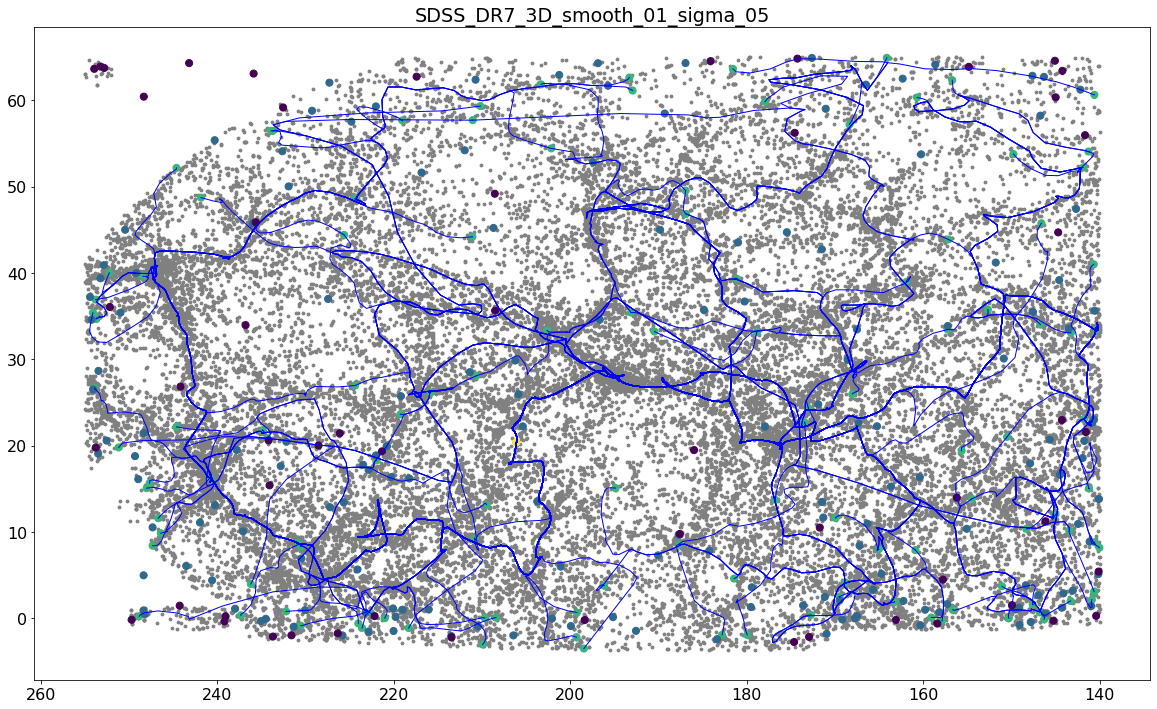

In [16]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 12))

plt.scatter(coma['RA'], coma['DEC'], c='grey', s=8)

x = []
y = []
c = []
for cp in cps:
    x.append(cp['RA'])
    y.append(cp['DEC'])
    c.append(cp['type'])
plt.scatter(x, y, c=c, s=50)
    

for fil in tqdm(fils):
    points = fil['sample_points']
    x = []
    y = []
    for i in range(len(points)):
        x.append(points[i][0])
        y.append(points[i][1])
    plt.plot(x, y, 'b', linewidth=1)
ax = fig.get_axes()
ax[0].invert_xaxis()
plt.title('SDSS_DR7_3D_smooth_01_sigma_05')
plt.savefig('3D_smooth_01_s_05')

In [17]:
center_ra = 194.9
center_dec = 28
radius = 5
big_radius = 40

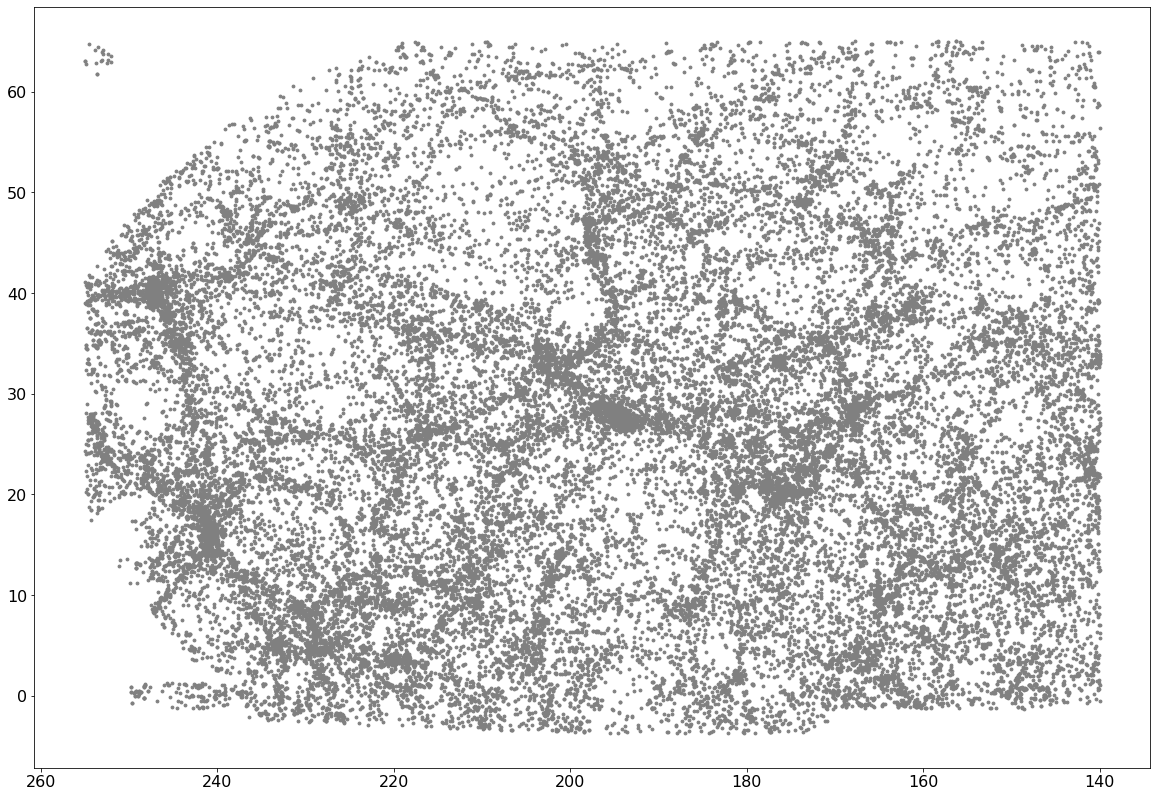

In [18]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 14))

plt.scatter(coma['RA'], coma['DEC'], c='grey', s=8)

from collections import deque
q = deque()
for i in range(len(cps)):
    if ((cps[i]['RA'] - center_ra) ** 2 + (cps[i]['DEC'] - center_dec) ** 2) ** 0.5 < radius:
        q.append(i)
x = []
y = []
c = []
proc_points = set()
while not (len(q) == 0):
    cp_idx = q.popleft()
    cp = cps[cp_idx]
    x.append(cp['RA'])
    y.append(cp['DEC'])
    c.append(cp['type'])
    for fil in fils:
        if fil['CP1_id'] == cp_idx or fil['CP2_id'] == cp_idx:
            points = fil['sample_points']
            fil_x = []
            fil_y = []
            for i in range(len(points)):
                fil_x.append(points[i][0])
                fil_y.append(points[i][1])
            plt.plot(fil_x, fil_y, 'b', linewidth=1)
            
            if fil['CP1_id'] == cp_idx and fil['CP2_id'] not in proc_points:
                cp = cps[fil['CP2_id']]
                if ((cp['RA'] - center_ra) ** 2 + (cp['DEC'] - center_dec) ** 2) ** 0.5 < big_radius:
                    q.append(fil['CP2_id'])
            if fil['CP2_id'] == cp_idx and fil['CP1_id'] not in proc_points:
                cp = cps[fil['CP1_id']]
                if ((cp['RA'] - center_ra) ** 2 + (cp['DEC'] - center_dec) ** 2) ** 0.5 < big_radius:
                    q.append(fil['CP1_id'])
    proc_points.add(cp_idx)

plt.scatter(x, y, c=c, s=50)
ax = fig.get_axes()
ax[0].invert_xaxis()